#### Import Necessary Libraries

In [1]:
import copy
from functools import partial
from tqdm import tqdm
from datetime import timedelta

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

### Load Data

In [2]:
DATE = '09-02-2025-NOON'
CRYPTO_PAIRS = ['BTCUSDT', 'ETHUSDT']
TICK_SIZES = { crypto_pair: 1e-2 for crypto_pair in CRYPTO_PAIRS }
LOT_SIZES = { 'BTCUSDT': 1e-5, 'ETHUSDT': 1e-4 }
ODB_DEPTH = 10
print(f'Loading Data of {DATE} for {CRYPTO_PAIRS}...')

Loading Data of 09-02-2025-NOON for ['BTCUSDT', 'ETHUSDT']...


In [3]:
# load data csv
data = {
    'DEPTH': { crypto_pair: pd.read_csv(f"../data/{DATE}/BINANCE-{crypto_pair}-DEPTH.csv") for crypto_pair in tqdm(CRYPTO_PAIRS) },
    'TRADE': { crypto_pair: pd.read_csv(f"../data/{DATE}/BINANCE-{crypto_pair}-TRADES.csv") for crypto_pair in tqdm(CRYPTO_PAIRS) }
}

# convert time column to datetime timestamps and then move it to index
for crypto_pair in CRYPTO_PAIRS:

    # remove the unecessary columns
    data['DEPTH'][crypto_pair].drop('timestamp', axis=1, inplace=True)
    data['TRADE'][crypto_pair].drop(['timestamp', 'E'], axis=1, inplace=True)

    data['DEPTH'][crypto_pair].E = pd.to_datetime(data['DEPTH'][crypto_pair].loc[:, 'E'], unit='ms')
    data['TRADE'][crypto_pair].T = pd.to_datetime(data['TRADE'][crypto_pair].loc[:, 'T'], unit='ms')

    data['DEPTH'][crypto_pair].set_index('E', inplace=True)
    data['TRADE'][crypto_pair].set_index('T', inplace=True)

    # sort index to prevent any discrepency
    # kind='mergesort' is important as we want the original order intact in case of ties
    data['DEPTH'][crypto_pair].sort_index(kind='mergesort', inplace=True)
    data['TRADE'][crypto_pair].sort_index(kind='mergesort', inplace=True)

    data['DEPTH'][crypto_pair].index.name = 'timestamp'
    data['TRADE'][crypto_pair].index.name = 'timestamp'

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


In [4]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,10.69103,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:01.814,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:01.914,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:02.014,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:02.114,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.47977,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.48261,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21713,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00772,0.06144,0.00006
2025-02-10 01:29:51.114,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21720,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00772,0.06144,0.00006
2025-02-10 01:29:51.214,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21720,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00761,0.06084,0.00006


In [5]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:01.423,96990.00,0.00689,0
2025-02-09 07:12:01.502,96990.00,0.00013,0
2025-02-09 07:12:01.544,96990.00,0.00102,0
2025-02-09 07:12:01.544,96990.00,0.00009,0
2025-02-09 07:12:01.544,96990.00,0.00306,0
...,...,...,...
2025-02-10 01:30:33.416,96212.19,0.00006,0
2025-02-10 01:30:33.416,96212.19,0.00006,0
2025-02-10 01:30:33.577,96212.19,0.00233,1


In [6]:
for crypto_pair in tqdm(CRYPTO_PAIRS):
    # the first row requires syncing orderbook so the timestamp in it is `0` which is not valid. So, we simply drop it.
    data['DEPTH'][crypto_pair].drop(data['DEPTH'][crypto_pair].index[:1], inplace=True)
    # only keep the trades that happen between the first and last timestamp in the depth dataframe
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair][np.logical_and(data['TRADE'][crypto_pair].index >= data['DEPTH'][crypto_pair].index[0], data['TRADE'][crypto_pair].index <= data['DEPTH'][crypto_pair].index[-1])]

100%|██████████| 2/2 [00:00<00:00, 12.41it/s]


In [7]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,96990.00,0.00015,0
2025-02-09 07:12:02.069,96990.00,0.02000,0
2025-02-09 07:12:02.071,96989.99,0.00096,1
2025-02-09 07:12:02.464,96990.00,0.01374,0
2025-02-09 07:12:03.252,96990.00,0.00289,0
...,...,...,...
2025-02-10 01:29:48.730,96200.01,0.01642,0
2025-02-10 01:29:49.639,96200.00,0.00029,1
2025-02-10 01:29:49.970,96200.01,0.00006,0


In [8]:
print('Checking for gaps in the depth data captured with time difference > 400ms...')
# No big gaps hence the integrity of the data upholds
for crypto_pair in CRYPTO_PAIRS:
    print(pd.Series(data['DEPTH'][crypto_pair].index).diff()[pd.Series(data['DEPTH'][crypto_pair].index).diff() > timedelta(milliseconds=400)])
# orderbook snapshots come on an average with a delay of 100ms and we are good.
# trades on the otherhand are real-time and can have occassional large gaps.

Checking for gaps in the depth data captured with time difference > 400ms...
Series([], Name: timestamp, dtype: timedelta64[ns])
Series([], Name: timestamp, dtype: timedelta64[ns])


### Preprocess Data

In [9]:
print('Preprocessing Data...')
# convert all the data from floating point to integers to make easier queue related calculations
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, ODB_DEPTH+1)] + [f'ap{i}' for i in range(1, ODB_DEPTH+1)]] = data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, ODB_DEPTH+1)] + [f'ap{i}' for i in range(1, ODB_DEPTH+1)]] / TICK_SIZES[crypto_pair]
    data['DEPTH'][crypto_pair].loc[:, [f'bv{i}' for i in range(1, ODB_DEPTH+1)] + [f'av{i}' for i in range(1, ODB_DEPTH+1)]] = data['DEPTH'][crypto_pair].loc[:, [f'bv{i}' for i in range(1, ODB_DEPTH+1)] + [f'av{i}' for i in range(1, ODB_DEPTH+1)]] / LOT_SIZES[crypto_pair]
    data['TRADE'][crypto_pair].loc[:, 'p'] = data['TRADE'][crypto_pair].p / TICK_SIZES[crypto_pair]
    data['TRADE'][crypto_pair].loc[:, 'q'] = data['TRADE'][crypto_pair].q / LOT_SIZES[crypto_pair]
    data['DEPTH'][crypto_pair].fillna(-1, inplace=True)
    data['TRADE'][crypto_pair].fillna(-1, inplace=True)
    data['DEPTH'][crypto_pair] = data['DEPTH'][crypto_pair].round().astype(int)
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair].round().astype(int)

Preprocessing Data...


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/mg/l90d6s9536n6mfzjbqgrxffm0000gn/T/ipykernel_70617/3783433093.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TRADE'][crypto_pair].fillna(-1, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


In [10]:
data['DEPTH']['BTCUSDT'].head(10)

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148073,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:01.914,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148073,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.014,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148073,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.114,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147977,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.214,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147894,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048273,29,18,18,18,18,18,18,24,1057
2025-02-09 07:12:02.314,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147978,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048273,29,18,18,18,18,18,18,24,1057
2025-02-09 07:12:02.414,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147978,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,29,18,18,18,18,18,18,24,1057
2025-02-09 07:12:02.514,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1145327,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2046887,29,18,18,18,18,18,18,24,1057
2025-02-09 07:12:02.614,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147980,18,18,18,30,5862,30,73024,12,12,9699000,9699022,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,2046911,30,29,18,18,18,18,18,12,24


In [11]:
data['TRADE']['BTCUSDT'].head(10)

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,9699000,15,0
2025-02-09 07:12:02.069,9699000,2000,0
2025-02-09 07:12:02.071,9698999,96,1
2025-02-09 07:12:02.464,9699000,1374,0
2025-02-09 07:12:03.252,9699000,289,0
2025-02-09 07:12:03.255,9699000,2000,0
2025-02-09 07:12:03.373,9699000,509,0
2025-02-09 07:12:03.751,9699000,369,0
2025-02-09 07:12:03.758,9699000,220,0


In [12]:
hehe = pd.to_datetime('2025-02-09 22:14:39.696')

In [13]:
# store the best prices and orders at new limit levels
best_prices = { crypto_pair: {'timestamp': list(), 'bp1': list(), 'ap1': list(), 'trade': list(), 'newlim': list()} for crypto_pair in CRYPTO_PAIRS }
# stores the trade orderbooks
trade_odbs = {crypto_pair: list() for crypto_pair in CRYPTO_PAIRS}
# stores the cancel orders
trade_cancel_orders = {crypto_pair: {'bid': list(), 'ask': list()} for crypto_pair in CRYPTO_PAIRS}

for crypto_pair in CRYPTO_PAIRS:
# for crypto_pair in ['ETHUSDT']:

    # convert the depth dataset into dictionary of price: val for easier handling
    odb_df2dict = data['DEPTH'][crypto_pair].to_dict(orient='records')
    odb_dict = copy.deepcopy(odb_df2dict)
    odb_tup_keys = [(f'bp{i}', f'bv{i}') for i in range(10, 0, -1)] + [(f'ap{i}', f'av{i}') for i in range(1, 11)]
    for i in tqdm(range(len(odb_dict))):
        odb_dict[i] = { odb_dict[i][p]: odb_dict[i][q] for p, q in odb_tup_keys }
        odb_dict[i]['t'] = data['DEPTH'][crypto_pair].index[i]
    
    # convert the trade dataset into dictionary of price: val for easier handling
    trade_dict = data['TRADE'][crypto_pair].to_dict(orient='records')
    for i in tqdm(range(len(trade_dict))):
        trade_dict[i] = { trade_dict[i]['p']: trade_dict[i]['q'], 'mm_buy': trade_dict[i]['mm_buy'] }
        trade_dict[i]['t'] = data['TRADE'][crypto_pair].index[i]

    odb_ptr, trade_ptr = 0, 0
    # next_odb = dict()
    temp_odb = dict() # accounts for cancelled orders that appear in between two orderbook depth snapshots [TO THE BEST OF KNOWLEDGE]
    temp_limits = dict() # accounts for new limit orders that appear in between two orderbook depth snapshots [TO THE BEST OF KNOWLEDGE]
    temp_best_bid, temp_best_ask = -1, -1 # -1 means undefined
    temp_prev_best_bid, temp_prev_best_ask = -1, -1 # stores them in case updating the best bid/best ask makes the current trade look like being on the wrong direction
    temp_best_bid_estimate, temp_best_ask_estimate = -1, -1 # in case one side of the orderbook is wiped. This stores the trade price on the missing side as the best price estimate
    is_newlim = 0 # indicator for whether the current trade is at a new limit level that is not accounted before
    bid_cancel_orders = dict() # stores the cancelled bid orders
    ask_cancel_orders = dict() # stores the cancelled ask orders

    for i in tqdm(range(len(odb_dict) + len(trade_dict))):

        if trade_ptr >= len(trade_dict) or odb_dict[odb_ptr]['t'] <= trade_dict[trade_ptr]['t']:

            # stores the current state of the orderbook depth
            temp_odb = copy.deepcopy(odb_dict[odb_ptr])
            del temp_odb['t']

            # TODO: deal with cancel orders here when the reference price changes after the last trade due to cancel orders in between

            if i > 0:
                temp_prev_best_bid = temp_best_bid
                temp_prev_best_ask = temp_best_ask
            temp_best_bid = odb_df2dict[odb_ptr]['bp1'] #temp_odb_list[9]
            temp_best_ask = odb_df2dict[odb_ptr]['ap1'] # temp_odb_list[10]
            if i == 0:
                temp_prev_best_bid = temp_best_bid
                temp_prev_best_ask = temp_best_ask
            
            # if the orderbook is less than 10 limits then -1s will be present in the keys remove them
            if -1 in temp_odb:
                del temp_odb[-1]

            # # stores the next state of the orderbook depth
            # next_odb = copy.deepcopy(odb_dict[odb_ptr+1])

            # print('------------- LIMIT ORDERBOOK SNAPSHOT -------------')
            # print('CURR ODB:', odb_dict[odb_ptr])
            # print('----------------------------------------------------')
            # print()

            best_prices[crypto_pair]['timestamp'].append(odb_dict[odb_ptr]['t'])
            best_prices[crypto_pair]['ap1'].append(temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate)
            best_prices[crypto_pair]['bp1'].append(temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate)
            best_prices[crypto_pair]['trade'].append(0)
            best_prices[crypto_pair]['newlim'].append(0)

            temp_limits = dict()
            bid_cancel_orders = dict() # TODO: deal with cancel orders here when the reference price changes after the last trade due to cancel orders in between
            ask_cancel_orders = dict() # TODO: deal with cancel orders here when the reference price changes after the last trade due to cancel orders in between
            odb_ptr += 1

        else:

            # get all the info from the trade
            trade_dict_list = list(trade_dict[trade_ptr].items())
            # get the price and quantity of trade
            p, q = trade_dict_list[0]
            # direction of trade
            mm_buy = trade_dict_list[1][-1]
            # time of trade
            t = trade_dict_list[-1][-1]

            # if it is a MM buy
            if mm_buy:
                prices = list(temp_odb.keys())
                # try to find better prices only when temp_best_bid is defined
                # o.w. most likely the ask side of the orderbook upto 10 limits which we keep track of is missing/lifted
                if temp_best_bid != -1:
                    # iterate over the temp_odb
                    for price in prices:
                        # check if there are better bid prices than p
                        if price <= temp_best_bid and price > p:
                            # if there are that means they are cancelled before this trade happened
                            bid_cancel_orders[price] = temp_odb[price]
                            del temp_odb[price]
                            # if the price which we deleted was the temp_best_bid
                            if price == temp_best_bid:
                                temp_prev_best_bid = temp_best_bid
                                # then set it to p
                                temp_best_bid = p
                    
                    if p < temp_best_bid:
                        temp_prev_best_bid = temp_best_bid
                        # then set it to p
                        temp_best_bid = p
            else:
                # do the same thing but for the sell side
                prices = list(temp_odb.keys())
                # try to find better prices only when temp_best_ask is defined
                # o.w. most likely the sell side of the orderbook upto 10 limits which we keep track of is missing/lifted
                if temp_best_ask != -1:
                    for price in prices[::-1]:
                        # check if there are better offer prices than p
                        if price >= temp_best_ask and price < p:
                            # if there are that means they are cancelled before this trade happened
                            ask_cancel_orders[price] = temp_odb[price]
                            del temp_odb[price]
                            # if the price which we deleted was the temp_best_ask
                            if price == temp_best_ask:
                                temp_prev_best_ask = temp_best_ask
                                # then set it to p
                                temp_best_ask = p
                    
                    if p > temp_best_ask:
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = p

            # if the price is present in the temp_orderbook we are maintaining
            if p in temp_odb:

                # make sure that it is not the case that the orderbook snapshot's bid level is now getting a MM sell trade
                # which can happen if after we have the orderbook snapshot the best bid moves down and the previous best bid now becomes best ask
                # therefore getting MM sell trade
                if (mm_buy and (p <= temp_best_bid if temp_best_bid != -1 else p <= temp_best_bid_estimate)) \
                    or ((not mm_buy) and (p >= temp_best_ask if temp_best_ask != -1 else p >= temp_best_ask_estimate)):
                
                    # check if the quantity traded at this price is possible
                    # o.w. it will mean new limit orders were added at this price level before this trade occured
                    if temp_odb[p] < q:
                        # Add this to the temp_limits dictionary to keep track of this inferred new limit order from this trade
                        # we are sure that there is atleast this much quantity of limit order added here (maybe even more, no way of being sure)
                        temp_limits[p] = temp_limits.get(p, 0) + q - temp_odb[p]
                        best_prices[crypto_pair]['newlim'].append((q - temp_odb[p]) * (1-2*mm_buy))
                        is_newlim = 1
                    else:
                        # the quantity of the trade is possible

                        # if temp_limits does not have this price level then we can safely subtract the quantity as no new limit order was added at this price level
                        if not temp_limits.get(p, 0):
                            temp_odb[p] -= q

                            # if all the quantity at this price level is exhausted remove the level
                            if temp_odb[p] == 0:
                                del temp_odb[p]

                                # set the temp_best_bid/temp_best_ask accordingly
                                if mm_buy == 1 and p == temp_best_bid:
                                    worse_prices = np.array([price for price in temp_odb.keys() if price < p])
                                    temp_prev_best_bid = temp_best_bid
                                    temp_best_bid = max(worse_prices) if worse_prices.shape[0] else -1
                                    # the best estimate of temp_best_bid
                                    if not worse_prices.shape[0]:
                                        temp_best_bid_estimate = p
                                
                                if mm_buy == 0 and p == temp_best_ask:
                                    worse_prices = np.array([price for price in temp_odb.keys() if price > p])
                                    temp_prev_best_ask = temp_best_ask
                                    temp_best_ask = min(worse_prices) if worse_prices.shape[0] else -1
                                    # the best estimate of temp_best_ask
                                    if not worse_prices.shape[0]:
                                        temp_best_ask_estimate = p
                
                else:

                    # this means we have got some trades in the spread and will definitely update the best bid/best ask
                    if mm_buy:
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = p
                    else:
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = p
                    
                    # add it to the temp_limits as this is a new limit order
                    temp_limits[p] = q
                    best_prices[crypto_pair]['newlim'].append(q * (1-2*mm_buy))
                    is_newlim = 1
                    
                    # now it might happen that the best bid has now crossed the previous best ask in which case we need to cancel all the asks in between
                    if mm_buy and p >= temp_best_ask:
                        
                        # cancel all intermediate asks
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price >= temp_best_ask and price <= p:
                                
                                # remove the ask price
                                ask_cancel_orders[price] = temp_odb[price]
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price > p])
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = min(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_ask
                        if not worse_prices.shape[0]: # it is rare case that the entire ask side is cancelled and we get a trade of MM buy beyond that
                            # if all the prices are exhausted on the other sell side then there is no way of inferring the best ask except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[10:] if price != 't' and price > p]
                            # if looking into the next orderbook state does not give us the best ask then simply set it to this buy order price
                            temp_best_ask_estimate = min(worse_next_odb_prices) if len(worse_next_odb_prices) else p+1 # if we don't find any price in the next orderbook also then heuristically put p+1
                    
                    # now it might happen that the best ask has now crossed the previous best bid in which case we need to cancell all the bids in between
                    if (not mm_buy) and p <= temp_best_bid:

                        # cancel all intermediate bids
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price <= temp_best_bid and price >= p:

                                # remove the bid price
                                bid_cancel_orders[price] = temp_odb[price]
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price < p])
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = max(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_bid
                        if not worse_prices.shape[0]:
                            # if all the prices are exhausted on the other side there is no way of inferring the best bid except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[:10] if price < p]
                            # if looking into next orderbook state does not give the required best bid then simply set it to this sell order price
                            temp_best_bid_estimate = max(worse_next_odb_prices) if len(worse_next_odb_prices) else p-1 # if we don't find any price in the next orderbook also then heuristically put p-1

            # if the price is not present in the temp_orderbook we are maintaining
            else:

                if (mm_buy and (p > temp_best_bid if temp_best_bid != -1 else p > temp_best_bid_estimate)) \
                    or ((not mm_buy) and (p < temp_best_ask if temp_best_ask != -1 else p < temp_best_ask_estimate)):

                    # this means we have got some trades in the spread and will definitely update the best bid/best ask
                    if mm_buy:
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = p

                        # the ask side of the orderbook is exhausted and the best bid now equal to the best ask
                        if temp_best_ask == -1 and temp_best_bid >= temp_best_ask_estimate:
                            # if all the prices are exhausted on the other sell side then there is no way of inferring the best ask except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[10:] if price != 't' and price > p]
                            # if looking into the next orderbook state does not give us the best ask then simply set it to this buy order price
                            temp_best_ask_estimate = min(worse_next_odb_prices) if len(worse_next_odb_prices) else p+1 # if we don't find any price in the next orderbook also then heuristically put p+1
                    else:
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = p

                        # the bid side of the orderbook is exhausted and the best ask now becomes equal to the best bid
                        if temp_best_bid == -1 and temp_best_ask <= temp_best_bid_estimate:
                            # if all the prices are exhausted on the other side there is no way of inferring the best bid except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[:10] if price < p]
                            # if looking into next orderbook state does not give the required best bid then simply set it to this sell order price
                            temp_best_bid_estimate = max(worse_next_odb_prices) if len(worse_next_odb_prices) else p-1 # if we don't find any price in the next orderbook also then heuristically put p+1
                    
                    # add it to the temp_limits as this is a new limit order
                    temp_limits[p] = q
                    best_prices[crypto_pair]['newlim'].append(q * (1-2*mm_buy))
                    is_newlim = 1

                    # now it might happen that the best bid has now crossed the previous best ask in which case we need to cancel all the asks in between
                    if mm_buy and p >= (temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate):
                        
                        # cancel all intermediate asks
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price >= temp_best_ask and price <= p:
                                
                                # remove the ask price
                                ask_cancel_orders[price] = temp_odb[price]
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price > p])
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = min(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_ask
                        if not worse_prices.shape[0]: # it is rare case that the entire ask side is cancelled and we get a trade of MM buy beyond that
                            # if all the prices are exhausted on the other sell side then there is no way of inferring the best ask except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[10:] if price != 't' and price > p]
                            # if looking into the next orderbook state does not give us the best ask then simply set it to this buy order price
                            temp_best_ask_estimate = min(worse_next_odb_prices) if len(worse_next_odb_prices) else p+1 # if we don't find any price in the next orderbook also then heuristically put p+1
                    
                    # now it might happen that the best ask has now crossed the previous best bid in which case we need to cancell all the bids in between
                    if (not mm_buy) and p <= (temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate):

                        # cancel all intermediate bids
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price <= temp_best_bid and price >= p:

                                # remove the bid price
                                bid_cancel_orders[price] = temp_odb[price]
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price < p])
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = max(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_bid
                        if not worse_prices.shape[0]:
                            # if all the prices are exhausted on the other side there is no way of inferring the best bid except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[:10] if price < p]
                            # if looking into next orderbook state does not give the required best bid then simply set it to this sell order price
                            temp_best_bid_estimate = max(worse_next_odb_prices) if len(worse_next_odb_prices) else p-1 # if we don't find any price in the next orderbook also then heuristically put p+1
                    
                else:

                    # This means that there is had been new limit orders waiting in the orderbook when the trade occurred
                    # Check if we have already accounted for this new trade
                    # if we have done so, then we can now say that the agg quantity at this new level was more than what we inferred before
                    # o.w. we have info that there are new limit orders at this new level with agg quantity at least that of the trade
                    temp_limits[p] = temp_limits.get(p, 0) + q
                    best_prices[crypto_pair]['newlim'].append(q * (1-2*mm_buy))
                    is_newlim = 1

                    # in case of missing side of orderbook we infer the trade price to happen at the best bid/best ask on the resp side (which is obv true)
                    if temp_best_ask == -1 and mm_buy == 0:
                        temp_best_ask_estimate = p
                    
                    if temp_best_bid == -1 and mm_buy == 1:
                        temp_best_bid_estimate = p

            # print(trade_dict[trade_ptr])
            # print('TEMP ODB:', temp_odb)
            # print('TEMP LIM:', temp_limits)
            # print(f'BEST BID: {temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate}, BEST ASK: {temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate}')
            # print()

            bb = temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate
            ba = temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate
            mp = (bb+ba)/2.0 # mid price

            # if the current buy order changes the mid price such that p > mp then we update the best bid to be inserted to the previous one
            # it happens mostly because some level got cleared hence updating the best bid but it makes the current trade look as if on the wrong side
            if mm_buy and p > mp:
                bb = temp_prev_best_bid if temp_best_bid != -1 else temp_best_bid_estimate
            
            # same for the ask side
            if (not mm_buy) and p < mp:
                ba = temp_prev_best_ask if temp_best_bid != -1 else temp_best_bid_estimate

            # store the temporary orderbooks at each trade and newly added limits to the lists
            trade_odbs[crypto_pair].append((t, copy.deepcopy(temp_odb)))

            # store the cancelled orders at each trade
            trade_cancel_orders[crypto_pair]['bid'].append(bid_cancel_orders)
            trade_cancel_orders[crypto_pair]['ask'].append(ask_cancel_orders)
            bid_cancel_orders, ask_cancel_orders = dict(), dict()

            best_prices[crypto_pair]['timestamp'].append(trade_dict[trade_ptr]['t'])
            best_prices[crypto_pair]['ap1'].append(ba)
            best_prices[crypto_pair]['bp1'].append(bb)
            best_prices[crypto_pair]['trade'].append(1)
            if is_newlim == 0:
                best_prices[crypto_pair]['newlim'].append(0)
            else:
                is_newlim = 0

            trade_ptr += 1

    # create a dataframe out of best_prices
    best_prices[crypto_pair] = pd.DataFrame(best_prices[crypto_pair])
    best_prices[crypto_pair].set_index('timestamp', inplace=True)

data['NEWLIM'] = {crypto_pair: best_prices[crypto_pair].query('trade == 1').copy(deep=True) for crypto_pair in CRYPTO_PAIRS}

100%|██████████| 2676299/2676299 [00:38<00:00, 68921.71it/s]


In [14]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,9699000,15,0
2025-02-09 07:12:02.069,9699000,2000,0
2025-02-09 07:12:02.071,9698999,96,1
2025-02-09 07:12:02.464,9699000,1374,0
2025-02-09 07:12:03.252,9699000,289,0
...,...,...,...
2025-02-10 01:29:48.730,9620001,1642,0
2025-02-10 01:29:49.639,9620000,29,1
2025-02-10 01:29:49.970,9620001,6,0


In [15]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148073,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:01.914,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148073,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.014,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148073,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.114,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147977,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.214,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147894,18,18,18,30,5862,30,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048273,29,18,18,18,18,18,18,24,1057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,37,29,25,18,18,18,29,24,7152,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621713,18,24375,7359,6,6,13,772,6144,6
2025-02-10 01:29:51.114,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,37,29,25,18,18,18,29,24,7152,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621720,18,24375,7359,6,6,13,772,6144,6
2025-02-10 01:29:51.214,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,37,29,25,18,18,18,29,24,7152,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621720,18,24375,7359,6,6,13,761,6084,6


In [16]:
best_prices['BTCUSDT'].query('newlim != 0')

,bp1,ap1,trade,newlim
timestamp,,,,
2025-02-09 07:12:10.707,9698999,9699084,1,6
2025-02-09 07:12:10.707,9698999,9699084,1,6
2025-02-09 07:12:10.707,9698999,9699133,1,6
2025-02-09 07:12:10.707,9698999,9699133,1,6
2025-02-09 07:12:10.707,9698999,9699133,1,6
...,...,...,...,...
2025-02-10 01:29:48.528,9620001,9620353,1,-6
2025-02-10 01:29:48.528,9620001,9620353,1,-6
2025-02-10 01:29:48.528,9620001,9620353,1,-6


In [17]:
print('Computing Reference Prices...')
# compute the bid-ask spreads
bid_ask_spreads = { crypto_pair: best_prices[crypto_pair].ap1 - best_prices[crypto_pair].bp1 for crypto_pair in CRYPTO_PAIRS }

# compute the reference price based on https://arxiv.org/pdf/1312.0563 section 2.2.2
reference_prices = { crypto_pair: (best_prices[crypto_pair].bp1 + best_prices[crypto_pair].ap1)/2 for crypto_pair in CRYPTO_PAIRS }

for crypto_pair in CRYPTO_PAIRS:
    even_bid_ask_spread_idx = np.where(bid_ask_spreads[crypto_pair] % 2 == 0)[0]
    candidate_reference_prices = pd.concat([reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] - 0.5, reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] + 0.5], axis=1)
    prev_reference_prices = reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx-1].to_numpy()
    reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] = candidate_reference_prices.to_numpy()[np.arange(candidate_reference_prices.shape[0]), np.argmin(np.abs(candidate_reference_prices.sub(prev_reference_prices, axis=0)), axis=1)]
    reference_prices[crypto_pair].name = 'rp'
    reference_prices[crypto_pair] = pd.concat([reference_prices[crypto_pair], best_prices[crypto_pair].trade], axis=1)


data['REFPRICE'] = copy.deepcopy(reference_prices)

Computing Reference Prices...


In [18]:
print('Reconstructing LOB from trades data...')
data['RDEPTH'] = {crypto_pair: None for crypto_pair in CRYPTO_PAIRS}
data['RDEPTHLEVELS'] = {crypto_pair: 0 for crypto_pair in CRYPTO_PAIRS}
for crypto_pair in CRYPTO_PAIRS:
    # get the list of prices and vols from the trade odb data
    trade_depth_prices = [list(temp_odb.keys()) for _, temp_odb in trade_odbs[crypto_pair]]
    trade_depth_vols = [list(temp_odb.values()) for _, temp_odb in trade_odbs[crypto_pair]]
    # max length of the trade odb for padding
    max_len = max(len(prices) for prices in trade_depth_prices)
    # padding
    trade_depth_prices = np.array([np.pad(prices, (0, max_len - len(prices)), mode='constant', constant_values=0) for prices in tqdm(trade_depth_prices)])
    trade_depth_vols = np.array([np.pad(vols, (0, max_len - len(vols)), mode='constant', constant_values=0) for vols in tqdm(trade_depth_vols)])
    trade_depth_prices = trade_depth_prices.astype(float)
    trade_depth_prices[trade_depth_prices == 0] = np.nan
    trade_depth_vols[trade_depth_vols == 0] = np.nan
    # get the mask indicating the bid prices and also correspondingly indicates the bid volumes
    bid_prices_mask = trade_depth_prices <= data['REFPRICE'][crypto_pair].query('trade == 1').rp.to_numpy()[:, np.newaxis]
    for i in tqdm(range(trade_depth_prices.shape[0])):
        mask = bid_prices_mask[i]
        trade_depth_prices[i, mask] = trade_depth_prices[i, mask][::-1]
        trade_depth_vols[i, mask] = trade_depth_vols[i, mask][::-1]

    # store the temp odb data
    trade_depth = np.zeros((len(trade_odbs[crypto_pair]), 4 * max_len), np.float64)
    trade_depth[:, :] = np.nan
    # store the trade's reconstructed orderbook in a structured format
    trade_depth[:, :max_len][bid_prices_mask] = trade_depth_prices[bid_prices_mask]
    trade_depth[:, max_len:(2*max_len)][bid_prices_mask] = trade_depth_vols[bid_prices_mask]
    trade_depth[:, (2*max_len):(3*max_len)][(~bid_prices_mask)[:,::-1]] = trade_depth_prices[~bid_prices_mask]
    trade_depth[:, (3*max_len):][(~bid_prices_mask)[:,::-1]] = trade_depth_vols[~bid_prices_mask]
    # convert the reconstructed orderbook from trades into dataframe
    # trade_depth = trade_depth.round().astype(int)
    trade_depth = pd.DataFrame(
        trade_depth, 
        columns=[f'bp{i}' for i in range(1,max_len+1)] + [f'bv{i}' for i in range(1,max_len+1)] \
            + [f'ap{i}' for i in range(1,max_len+1)] + [f'av{i}' for i in range(1,max_len+1)], 
            index=data['REFPRICE'][crypto_pair].query('trade == 1').index)
    data['RDEPTH'][crypto_pair] = trade_depth
    data['RDEPTHLEVELS'][crypto_pair] = max_len

Reconstructing LOB from trades data...


100%|██████████| 2023657/2023657 [00:06<00:00, 321388.64it/s]


In [19]:
data['RDEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bp11,bp12,bp13,bp14,bp15,bp16,bp17,bp18,bp19,bp20,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,bv11,bv12,bv13,bv14,bv15,bv16,bv17,bv18,bv19,bv20,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,ap11,ap12,ap13,ap14,ap15,ap16,ap17,ap18,ap19,ap20,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10,av11,av12,av13,av14,av15,av16,av17,av18,av19,av20
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:02.067,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1148073.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2050273.0,29.0,18.0,30.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:02.069,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1148073.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2048273.0,29.0,18.0,30.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:02.071,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1147977.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2048273.0,29.0,18.0,30.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:02.464,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1147978.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046887.0,29.0,18.0,18.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:03.252,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267387.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699022.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046562.0,18.0,29.0,18.0,18.0,18.0,18.0,18.0,12.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:48.730,9620000.0,9619993.0,9619928.0,9619922.0,9619876.0,9619875.0,9619860.0,9619821.0,9619801.0,9619800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024503.0,37.0,29.0,25.0,30.0,318.0,18.0,29.0,24.0,7152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9620001.0,9620002.0,9620036.0,9620037.0,9620038.0,9620056.0,9620079.0,9620083.0,9620199.0,9620200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,603213.0,6.0,18.0,7299.0,6.0,6.0,13.0,6.0,12.0,7140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 01:29:49.639,9620000.0,9619993.0,9619928.0,9619922.0,9619876.0,9619875.0,9619860.0,9619821.0,9619801.0,9619800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021155.0,37.0,29.0,25.0,18.0,18.0,18.0,29.0,24.0,7092.0,N

In [20]:
print('Reconstructing Cancel Orders from trades...')
data['CANCEL'] = {crypto_pair: None for crypto_pair in CRYPTO_PAIRS}
for crypto_pair in CRYPTO_PAIRS:
    # get the list of prices and vols from the cancelled orders data
    trade_cancel_bprices = [list(co.keys()) for co in trade_cancel_orders[crypto_pair]['bid']]
    trade_cancel_bvols = [list(co.values()) for co in trade_cancel_orders[crypto_pair]['bid']]
    trade_cancel_aprices = [list(co.keys()) for co in trade_cancel_orders[crypto_pair]['ask']]
    trade_cancel_avols = [list(co.values()) for co in trade_cancel_orders[crypto_pair]['ask']]
    # max length of the trade cancell orders for padding
    max_len = 10
    # padding
    trade_cancel_bprices = np.array([np.pad(prices[::-1], (0, max_len - len(prices)), mode='constant', constant_values=0) for prices in tqdm(trade_cancel_bprices)])
    trade_cancel_bvols = np.array([np.pad(vols[::-1], (0, max_len - len(vols)), mode='constant', constant_values=0) for vols in tqdm(trade_cancel_bvols)])
    trade_cancel_aprices = np.array([np.pad(prices, (0, max_len - len(prices)), mode='constant', constant_values=0) for prices in tqdm(trade_cancel_aprices)])
    trade_cancel_avols = np.array([np.pad(vols, (0, max_len - len(vols)), mode='constant', constant_values=0) for vols in tqdm(trade_cancel_avols)])
    trade_cancel_bprices = trade_cancel_bprices.astype(float)
    trade_cancel_aprices = trade_cancel_aprices.astype(float)
    trade_cancel_bprices[trade_cancel_bprices == 0] = np.nan
    trade_cancel_aprices[trade_cancel_aprices == 0] = np.nan
    trade_cancel_bvols[trade_cancel_bvols == 0] = np.nan
    trade_cancel_avols[trade_cancel_avols == 0] = np.nan

    # store the temp odb data
    trade_cancel = np.zeros((len(trade_cancel_orders[crypto_pair]['bid']), 4 * max_len), np.float64)
    trade_cancel[:, :] = np.nan
    # store the trade's reconstructed orderbook in a structured format
    trade_cancel[:, :max_len] = trade_cancel_bprices
    trade_cancel[:, max_len:(2*max_len)] = trade_cancel_bvols
    trade_cancel[:, (2*max_len):(3*max_len)] = trade_cancel_aprices
    trade_cancel[:, (3*max_len):] = trade_cancel_avols
    # convert the reconstructed orderbook from trades into dataframe
    # trade_depth = trade_depth.round().astype(int)
    trade_cancel = pd.DataFrame(
        trade_cancel, 
        columns=[f'bp{i}' for i in range(1,max_len+1)] + [f'bv{i}' for i in range(1,max_len+1)] \
            + [f'ap{i}' for i in range(1,max_len+1)] + [f'av{i}' for i in range(1,max_len+1)], 
            index=data['REFPRICE'][crypto_pair].query('trade == 1').index)
    data['CANCEL'][crypto_pair] = trade_cancel

Reconstructing Cancel Orders from trades...


100%|██████████| 2023657/2023657 [00:16<00:00, 119200.51it/s]


Visualizing Reference Price Movement...


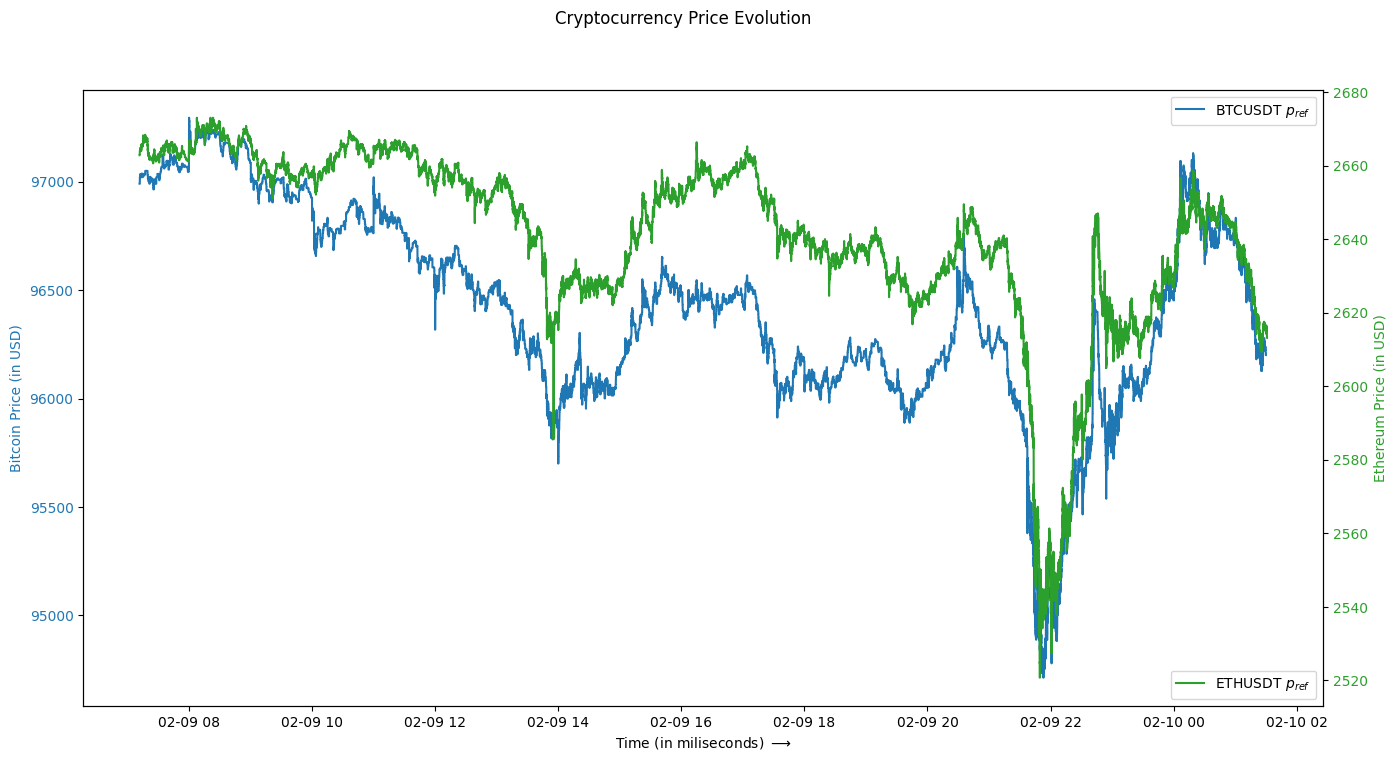

In [21]:
print('Visualizing Reference Price Movement...')
fig, ax1 = plt.subplots(figsize=(16, 8)) 
color = 'tab:blue'
ax1.plot(data['REFPRICE']['BTCUSDT'].rp * TICK_SIZES['BTCUSDT'], color = color, label='BTCUSDT $p_{ref}$')
ax1.legend()
ax1.set_xlabel('Time (in miliseconds) $\longrightarrow$')
ax1.set_ylabel("Bitcoin Price (in USD)", color = color)
ax1.tick_params(axis ='y', labelcolor = color) 

ax2 = ax1.twinx() 
 
color = 'tab:green'
ax2.set_ylabel('Ethereum Price (in USD)', color = color) 
ax2.plot(data['REFPRICE']['ETHUSDT'].rp * TICK_SIZES['ETHUSDT'], color = color, label='ETHUSDT $p_{ref}$') 
ax2.tick_params(axis ='y', labelcolor = color) 
ax2.legend(loc='lower right')

fig.suptitle('Cryptocurrency Price Evolution')
plt.show()

In [22]:
print('Visualizing Reconstructed Price Path between LOB Snapshots...')
# pick a time where the price difference between reference price of the LOB snapshots is high to illustrate
# the reconstructed path better
data['REFPRICE']['BTCUSDT'].query('trade==0').diff().rp.sort_values(ascending=False).iloc[1000:1005]

Visualizing Reconstructed Price Path between LOB Snapshots...


timestamp
2025-02-09 16:06:47.014    1069.0
2025-02-09 22:14:39.717    1069.0
2025-02-09 22:56:19.114    1068.0
2025-02-09 16:31:20.414    1067.0
2025-02-09 17:03:59.814    1066.0
Name: rp, dtype: float64

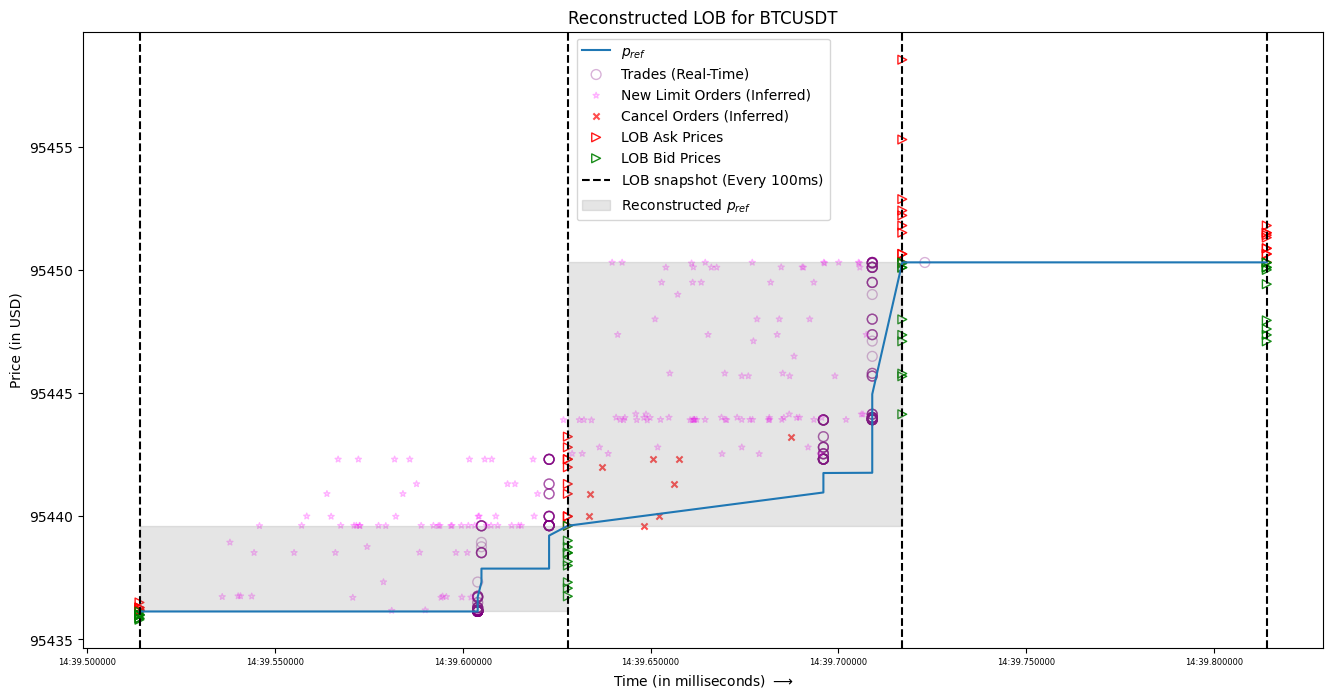

In [103]:
chosen_data = data['REFPRICE']['BTCUSDT'].loc['2025-02-09 22:14:39.5':'2025-02-09 22:14:39.9']
depth_data = data['DEPTH']['BTCUSDT'].loc['2025-02-09 22:14:39.5':'2025-02-09 22:14:39.9']
trades_data = data['TRADE']['BTCUSDT'].loc['2025-02-09 22:14:39.5':'2025-02-09 22:14:39.9']
cancelled_asks = data['CANCEL']['BTCUSDT'].loc['2025-02-09 22:14:39.5':'2025-02-09 22:14:39.9'].query('ap1 > 0')
newlim_orders = data['NEWLIM']['BTCUSDT'].loc['2025-02-09 22:14:39.5':'2025-02-09 22:14:39.9'].query('newlim != 0')
newlim_prices = newlim_orders.loc[:,'bp1':'ap1'].to_numpy()[np.arange(newlim_orders.shape[0]), np.maximum(np.sign(newlim_orders.newlim), 0)]
odb_timestamps = chosen_data.query('trade==0').index
plt.figure(figsize=(16, 8))
plt.plot(chosen_data.rp * TICK_SIZES['BTCUSDT'], label='$p_{ref}$')
# plt.scatter(chosen_data.query('trade==1').index, chosen_data.query('trade==1').rp * TICK_SIZES['BTCUSDT'], s=20, facecolors='none', edgecolors='r', label='Trades (Real-Time)')
plt.scatter(trades_data.index, trades_data.p * TICK_SIZES['BTCUSDT'], s=50, facecolors='none', edgecolors='purple', alpha=0.3, label='Trades (Real-Time)')
plt.scatter(newlim_orders.index.to_numpy() - pd.to_timedelta(np.random.uniform(0, 0.07, newlim_orders.shape[0]), unit='s'), newlim_prices * TICK_SIZES['BTCUSDT'], s=20, facecolors='none', edgecolors='magenta', alpha=0.3, marker='*', label='New Limit Orders (Inferred)')
for i in range(cancelled_asks.shape[0]):
    temp = cancelled_asks.iloc[i]
    ca = temp.loc['ap1':'ap10'].to_numpy()
    ca = ca[~np.isnan(ca)]
    if i == 0:
        plt.scatter(np.array([cancelled_asks.iloc[i].name]*ca.shape[0], dtype='datetime64[ns]') - pd.to_timedelta(np.random.uniform(0.03, 0.07, ca.shape[0]), unit='s'), ca * TICK_SIZES['BTCUSDT'], s=20, alpha=0.7, facecolors='red', marker='x', label='Cancel Orders (Inferred)')
    else:
        plt.scatter(np.array([cancelled_asks.iloc[i].name]*ca.shape[0], dtype='datetime64[ns]') - pd.to_timedelta(np.random.uniform(0, 0.07-i/35, ca.shape[0]), unit='s'), ca * TICK_SIZES['BTCUSDT'], s=20, alpha=0.7, facecolors='red', marker='x')
for i in range(depth_data.shape[0]):
    if i == 0: 
        plt.scatter([depth_data.iloc[i].name]*10, depth_data.iloc[i].loc['ap1':'ap10'].to_numpy() * TICK_SIZES['BTCUSDT'], s=40, marker='>', facecolors='none', edgecolors='red', alpha = 0.9, label='LOB Ask Prices')
    else:
        plt.scatter([depth_data.iloc[i].name]*10, depth_data.iloc[i].loc['ap1':'ap10'].to_numpy() * TICK_SIZES['BTCUSDT'], s=40, marker='>', facecolors='none', edgecolors='red', alpha = 0.9)
for i in range(depth_data.shape[0]):
    if i == 0: 
        plt.scatter([depth_data.iloc[i].name]*10, depth_data.iloc[i].loc['bp1':'bp10'].to_numpy() * TICK_SIZES['BTCUSDT'], s=40, marker='>', facecolors='none', edgecolors='green', alpha = 0.9, label='LOB Bid Prices')
    else:
        plt.scatter([depth_data.iloc[i].name]*10, depth_data.iloc[i].loc['bp1':'bp10'].to_numpy() * TICK_SIZES['BTCUSDT'], s=40, marker='>', facecolors='none', edgecolors='green', alpha = 0.9)
k = 0
for odb_timestamp in odb_timestamps:
    if k == 0:
        plt.axvline(odb_timestamp, linestyle='--', color='k', label='LOB snapshot (Every $100$ms)')
    else:
        plt.axvline(odb_timestamp, linestyle='--', color='k')
    if k == len(odb_timestamps)-1:
        break
    if k == 0:
        plt.fill_between(
            x=[odb_timestamps[k], odb_timestamps[k+1]], 
            y2=[min(chosen_data.loc[odb_timestamps[k]:odb_timestamps[k+1]].rp) * TICK_SIZES['BTCUSDT']]*2, y1=[max(chosen_data.loc[odb_timestamps[k]:odb_timestamps[k+1]].rp) * TICK_SIZES['BTCUSDT']]*2, 
            interpolate=True, color='gray', alpha=0.2, label='Reconstructed $p_{ref}$')
    else:
        plt.fill_between(
            x=[odb_timestamps[k], odb_timestamps[k+1]], 
            y2=[min(chosen_data.loc[odb_timestamps[k]:odb_timestamps[k+1]].rp) * TICK_SIZES['BTCUSDT']]*2, y1=[max(chosen_data.loc[odb_timestamps[k]:odb_timestamps[k+1]].rp) * TICK_SIZES['BTCUSDT']]*2, 
            interpolate=True, color='gray', alpha=0.2)
    k += 1

plt.legend()
plt.xticks(fontsize=6)
plt.xlabel('Time (in milliseconds) $\longrightarrow$')
plt.ylabel('Price (in USD)')
plt.title('Reconstructed LOB for BTCUSDT')
plt.show()
# plt.plot(data['REFPRICE']['ETHUSDT'].rp * TICK_SIZES['ETHUSDT'])
# plt.xticks(fontsize=6)
# # plt.ylim(2500, 2700)
# plt.show()

In [23]:
data['REFPRICE']['BTCUSDT']

,rp,trade
timestamp,,
2025-02-09 07:12:01.814,9698999.5,0
2025-02-09 07:12:01.914,9698999.5,0
2025-02-09 07:12:02.014,9698999.5,0
2025-02-09 07:12:02.067,9698999.5,1
2025-02-09 07:12:02.069,9698999.5,1
...,...,...
2025-02-10 01:29:51.014,9620000.5,0
2025-02-10 01:29:51.114,9620000.5,0
2025-02-10 01:29:51.214,9620000.5,0


In [24]:
data['RDEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bp11,bp12,bp13,bp14,bp15,bp16,bp17,bp18,bp19,bp20,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,bv11,bv12,bv13,bv14,bv15,bv16,bv17,bv18,bv19,bv20,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,ap11,ap12,ap13,ap14,ap15,ap16,ap17,ap18,ap19,ap20,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10,av11,av12,av13,av14,av15,av16,av17,av18,av19,av20
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:02.067,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1148073.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2050273.0,29.0,18.0,30.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:02.069,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1148073.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2048273.0,29.0,18.0,30.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:02.071,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1147977.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2048273.0,29.0,18.0,30.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:02.464,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1147978.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,9699134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046887.0,29.0,18.0,18.0,18.0,18.0,18.0,18.0,24.0,1057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-09 07:12:03.252,9698999.0,9698998.0,9698997.0,9698996.0,9698991.0,9698990.0,9698981.0,9698980.0,9698979.0,9698978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267387.0,18.0,18.0,18.0,30.0,5862.0,30.0,73024.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9699000.0,9699022.0,9699030.0,9699043.0,9699046.0,9699047.0,9699066.0,9699076.0,9699084.0,9699133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046562.0,18.0,29.0,18.0,18.0,18.0,18.0,18.0,12.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:48.730,9620000.0,9619993.0,9619928.0,9619922.0,9619876.0,9619875.0,9619860.0,9619821.0,9619801.0,9619800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1024503.0,37.0,29.0,25.0,30.0,318.0,18.0,29.0,24.0,7152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9620001.0,9620002.0,9620036.0,9620037.0,9620038.0,9620056.0,9620079.0,9620083.0,9620199.0,9620200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,603213.0,6.0,18.0,7299.0,6.0,6.0,13.0,6.0,12.0,7140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 01:29:49.639,9620000.0,9619993.0,9619928.0,9619922.0,9619876.0,9619875.0,9619860.0,9619821.0,9619801.0,9619800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021155.0,37.0,29.0,25.0,18.0,18.0,18.0,29.0,24.0,7092.0,N

In [25]:
data['NEWLIM'][crypto_pair]

,bp1,ap1,trade,newlim
timestamp,,,,
2025-02-09 07:12:02.193,266279,266280,1,0
2025-02-09 07:12:02.213,266279,266280,1,0
2025-02-09 07:12:02.213,266279,266280,1,0
2025-02-09 07:12:02.761,266279,266280,1,0
2025-02-09 07:12:02.761,266279,266280,1,0
...,...,...,...,...
2025-02-10 01:30:53.220,261312,261348,1,-21
2025-02-10 01:30:53.220,261312,261348,1,-1
2025-02-10 01:30:53.248,261312,261313,1,101


In [26]:
data['REFPRICE']['BTCUSDT']

,rp,trade
timestamp,,
2025-02-09 07:12:01.814,9698999.5,0
2025-02-09 07:12:01.914,9698999.5,0
2025-02-09 07:12:02.014,9698999.5,0
2025-02-09 07:12:02.067,9698999.5,1
2025-02-09 07:12:02.069,9698999.5,1
...,...,...
2025-02-10 01:29:51.014,9620000.5,0
2025-02-10 01:29:51.114,9620000.5,0
2025-02-10 01:29:51.214,9620000.5,0


In [ ]:
print('Converting Depth and Trades data to Queue Numbers...')
# convert the depth prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = data['DEPTH'][crypto_pair].copy(deep=True)
    temp['rp'] = data['REFPRICE'][crypto_pair].query('trade == 0').rp.to_numpy()
    # all the positions in the depth data which are -1 are actually missing values and hence replace that with None to be replaced later after subtraction with 0 as there is no queue which has queue number 0
    data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'] = data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'].mask(data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'] == -1, np.nan).sub(temp.rp, axis=0) - 0.5
    data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'] = data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'].mask(data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'] == -1, np.nan).sub(temp.rp, axis=0) + 0.5
    data['DEPTH'][crypto_pair].fillna(0, inplace=True)
    data['DEPTH'][crypto_pair] = data['DEPTH'][crypto_pair].round().astype(int)

# convert the rdepth prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = data['RDEPTH'][crypto_pair].copy(deep=True)
    temp['rp'] = data['REFPRICE'][crypto_pair].query('trade == 1').rp.to_numpy()
    data['RDEPTH'][crypto_pair].loc[:, 'bp1':f"bp{data['RDEPTHLEVELS'][crypto_pair]}"] = data['RDEPTH'][crypto_pair].loc[:, 'bp1':f"bp{data['RDEPTHLEVELS'][crypto_pair]}"].sub(temp.rp, axis=0) - 0.5
    data['RDEPTH'][crypto_pair].loc[:, 'ap1':f"ap{data['RDEPTHLEVELS'][crypto_pair]}"] = data['RDEPTH'][crypto_pair].loc[:, 'ap1':f"ap{data['RDEPTHLEVELS'][crypto_pair]}"].sub(temp.rp, axis=0) + 0.5
    data['RDEPTH'][crypto_pair].fillna(0, inplace=True)
    data['RDEPTH'][crypto_pair] = data['RDEPTH'][crypto_pair].round().astype(int)
    # now do the same for new limit orders that arrived in the trades
    data['NEWLIM'][crypto_pair].loc[:, 'bp1'] = data['NEWLIM'][crypto_pair].loc[:, 'bp1'].sub(temp.rp, axis=0) - 0.5
    data['NEWLIM'][crypto_pair].loc[:, 'ap1'] = data['NEWLIM'][crypto_pair].loc[:, 'ap1'].sub(temp.rp, axis=0) + 0.5
    data['NEWLIM'][crypto_pair] = data['NEWLIM'][crypto_pair].loc[:, ['bp1', 'ap1', 'newlim']]
    data['NEWLIM'][crypto_pair] = data['NEWLIM'][crypto_pair].round().astype(int)

# convert the cancel prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = data['REFPRICE'][crypto_pair].copy(deep=True)
    temp['rp'] = temp['rp'].shift(1).to_numpy()
    temp = temp.query('trade == 1')
    data['CANCEL'][crypto_pair].loc[:, 'bp1':'bp10'] = data['CANCEL'][crypto_pair].loc[:, 'bp1':'bp10'].sub(temp.rp, axis=0) - 0.5
    data['CANCEL'][crypto_pair].loc[:, 'ap1':'ap10'] = data['CANCEL'][crypto_pair].loc[:, 'ap1':'ap10'].sub(temp.rp, axis=0) + 0.5
    data['CANCEL'][crypto_pair].fillna(0, inplace=True)
    data['CANCEL'][crypto_pair] = data['CANCEL'][crypto_pair].round().astype(int)

Converting Depth and Trades data to Queue Numbers...


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


In [41]:
# convert the trade prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = data['TRADE'][crypto_pair].copy(deep=True)
    temp['rp'] = data['REFPRICE'][crypto_pair].query('trade == 1').rp.to_numpy()
    temp_adj_factor = (data['TRADE'][crypto_pair].mm_buy * 2 - 1) * -0.5
    data['TRADE'][crypto_pair].p = temp.p - temp.rp + temp_adj_factor
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair].round().astype(int)

100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


In [42]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148073,18,18,18,30,5862,30,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:01.914,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148073,18,18,18,30,5862,30,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.014,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1148073,18,18,18,30,5862,30,73024,12,12,1,31,44,47,48,67,77,85,134,135,2050288,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.114,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1147977,18,18,18,30,5862,30,73024,12,12,1,31,44,47,48,67,77,85,134,135,2048261,29,18,30,18,18,18,18,24,1057
2025-02-09 07:12:02.214,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1147894,18,18,18,30,5862,30,73024,12,12,1,31,44,47,48,67,77,85,134,135,2048273,29,18,18,18,18,18,18,24,1057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,37,29,25,18,18,18,29,24,7152,1,35,36,37,38,56,79,112,115,153,621713,18,24375,7359,6,6,13,772,6144,6
2025-02-10 01:29:51.114,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,37,29,25,18,18,18,29,24,7152,1,35,36,37,38,56,79,112,115,153,621720,18,24375,7359,6,6,13,772,6144,6
2025-02-10 01:29:51.214,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1035129,37,29,25,18,18,18,29,24,7152,1,35,36,37,38,56,79,112,115,153,621720,18,24375,7359,6,6,13,761,6084,6


In [43]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,1,15,0
2025-02-09 07:12:02.069,1,2000,0
2025-02-09 07:12:02.071,-1,96,1
2025-02-09 07:12:02.464,1,1374,0
2025-02-09 07:12:03.252,1,289,0
...,...,...,...
2025-02-10 01:29:48.730,1,1642,0
2025-02-10 01:29:49.639,-1,29,1
2025-02-10 01:29:49.970,1,6,0


In [44]:
# perform queue number validation checks
print('Performing Validation Checks for Trade Queue Numbers...')
for crypto_pair in CRYPTO_PAIRS:
    print(f'Checking {crypto_pair}...')
    print('Case 1: p > 0, mm_buy == 1')
    print(data['TRADE'][crypto_pair].query('p > 0 & mm_buy == 1'))
    print('Case 2: p < 0, mm_buy == 0')
    print(data['TRADE'][crypto_pair].query('p < 0 & mm_buy == 0'))
    print('Case 3: p == 0, mm_buy == 1')
    print(data['TRADE'][crypto_pair].query('p == 0 & mm_buy == 1'))
    print('Case 4: p == 0, mm_buy == 0')
    print(data['TRADE'][crypto_pair].query('p == 0 & mm_buy == 0'))

Performing Validation Checks for Trade Queue Numbers...
Checking BTCUSDT...
Case 1: p > 0, mm_buy == 1
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Case 2: p < 0, mm_buy == 0
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Case 3: p == 0, mm_buy == 1
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Case 4: p == 0, mm_buy == 0
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Checking ETHUSDT...
Case 1: p > 0, mm_buy == 1
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Case 2: p < 0, mm_buy == 0
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Case 3: p == 0, mm_buy == 1
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []
Case 4: p == 0, mm_buy == 0
Empty DataFrame
Columns: [p, q, mm_buy]
Index: []


In [45]:
print('Computing ATS...')
# compute the average trade size
data['ATS'] = { crypto_pair: data['TRADE'][crypto_pair].groupby('p').q.mean().sort_index() for crypto_pair in CRYPTO_PAIRS }
for crypto_pair in CRYPTO_PAIRS:
    data['ATS'][crypto_pair][0] = 1
    data['ATS'][crypto_pair].sort_index(inplace=True)
data['ATS']['BTCUSDT']

Computing ATS...


p
-11845      54.000000
-6345      264.000000
-5613      738.500000
-5604        6.000000
-5587        6.000000
             ...     
 13470      35.000000
 13482       6.000000
 13490      48.000000
 13491      58.666667
 13501    3108.276074
Name: q, Length: 9296, dtype: float64

In [46]:
# compute the queue numbers present in the LOB snapshots
depth_queue_numbers = {crypto_pair: pd.Series(data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, 11)] + [f'ap{i}' for i in range(1, 11)]].to_numpy().ravel()).value_counts().sort_index() for crypto_pair in CRYPTO_PAIRS}
depth_queue_numbers['BTCUSDT']

-6422973      1
-6412595      1
-6406800      3
-6374001      1
-6353217      1
             ..
 2911487      6
 2912026     11
 3857442      1
 4036996      1
 26630530     1
Name: count, Length: 8555, dtype: int64

Visualizing the Queue Numbers present in the LOB snapshots....


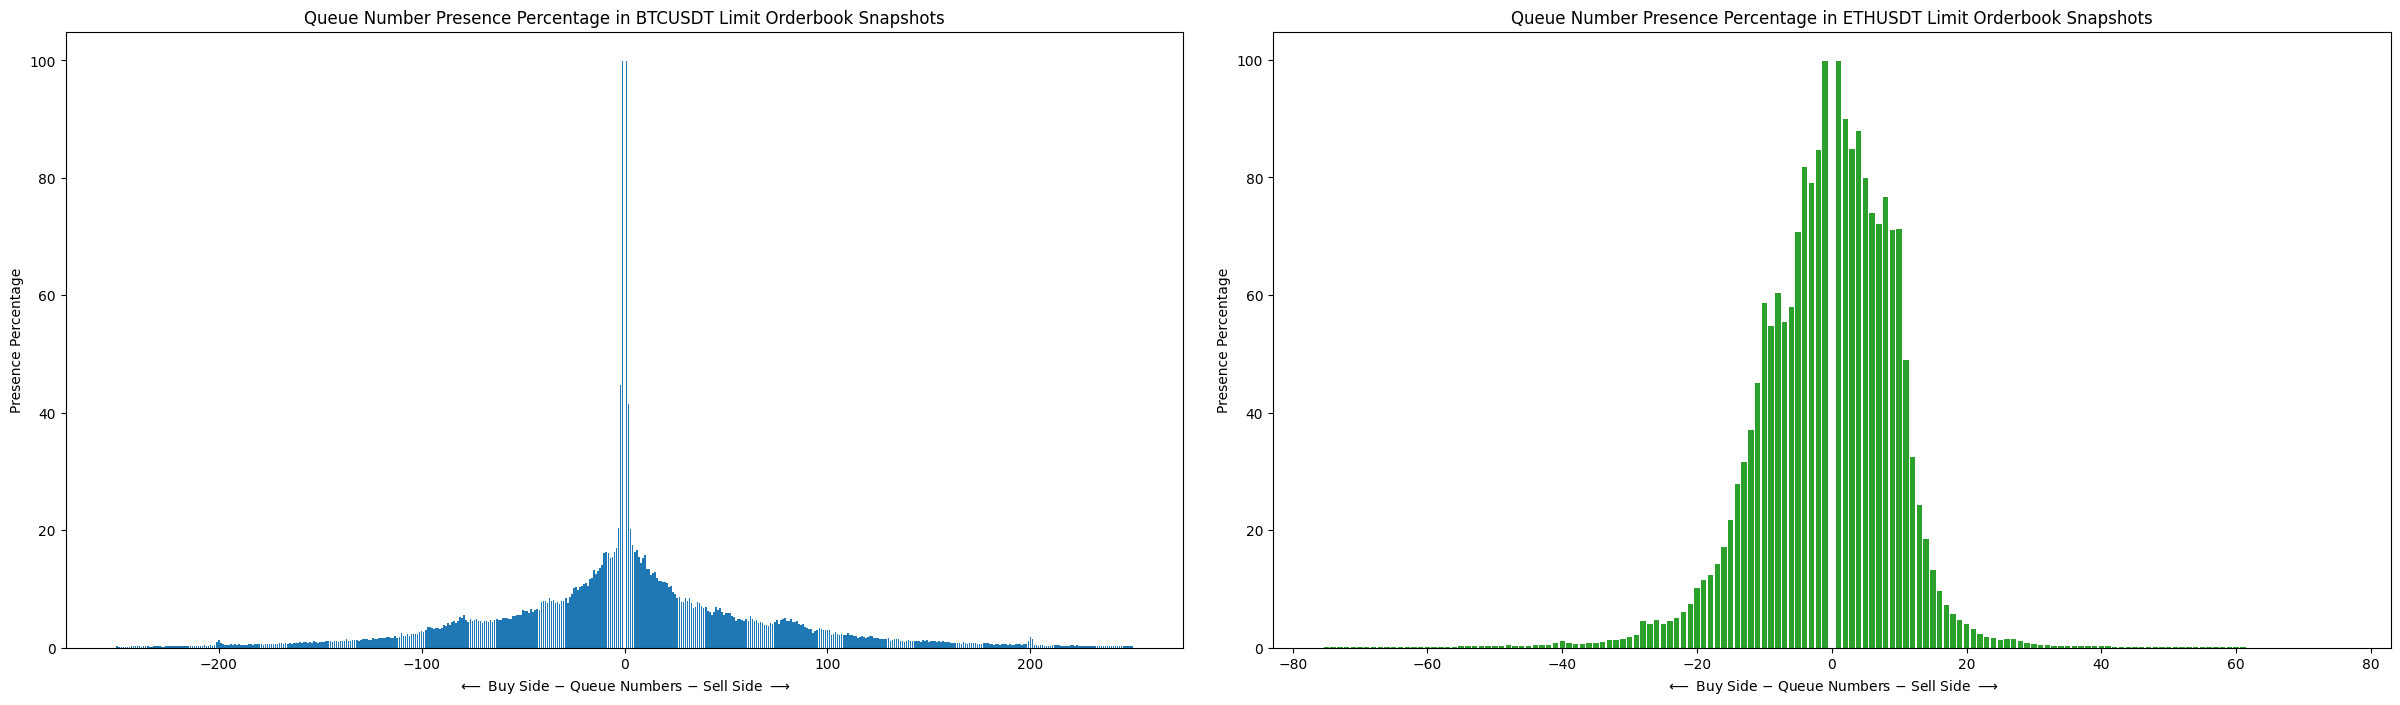

In [47]:
print('Visualizing the Queue Numbers present in the LOB snapshots....')
fig, axes = plt.subplots(1, 2, figsize=(30, 8))

for i, crypto_pair in enumerate(CRYPTO_PAIRS):

    K = 75 if crypto_pair == 'ETHUSDT' else 250
    color = 'tab:blue' if crypto_pair == 'BTCUSDT' else 'tab:green'
    queue_numbers = np.array(depth_queue_numbers[crypto_pair].index)
    plot_queue_numbers = queue_numbers[np.logical_and(queue_numbers >= -K, queue_numbers <= K)]
    plot_queue_numbers = [qn for qn in plot_queue_numbers if qn != 0] # 0 means not a valid queue/ no queue

    axes[i].bar(plot_queue_numbers, depth_queue_numbers[crypto_pair].loc[plot_queue_numbers] * 100 / data['DEPTH'][crypto_pair].shape[0], color=color)
    axes[i].set_title(f'Queue Number Presence Percentage in {crypto_pair} Limit Orderbook Snapshots')
    axes[i].set_ylabel('Presence Percentage')
    axes[i].set_xlabel('$\longleftarrow$ Buy Side $-$ Queue Numbers $-$ Sell Side $\longrightarrow$')

# adjust space between the two subplots
plt.subplots_adjust(wspace=0.08)
plt.show()

Visualizing the ATS...


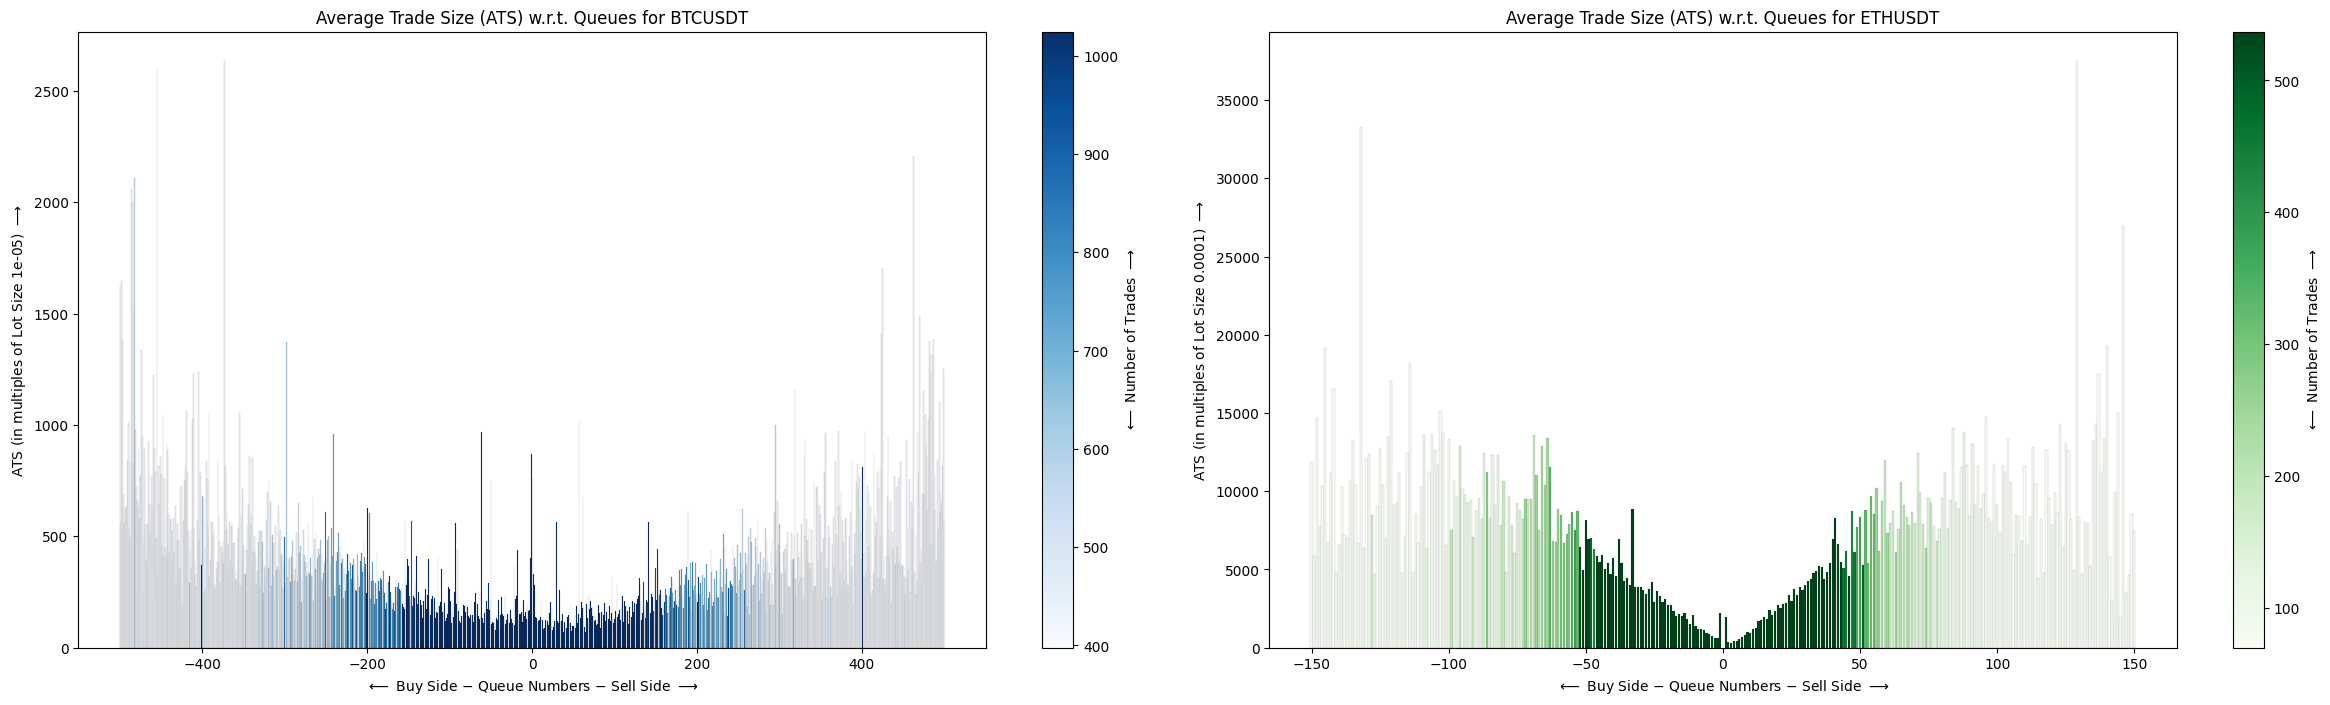

In [48]:
print('Visualizing the ATS...')
fig, axes = plt.subplots(1, 2, figsize=(30, 8))

for i, crypto_pair in enumerate(CRYPTO_PAIRS):

    K = 150 if crypto_pair == 'ETHUSDT' else 500
    colorfam = 'Blues' if crypto_pair == 'BTCUSDT' else 'Greens'
    queue_numbers = np.array([qn for qn in data['ATS'][crypto_pair].index if qn != 0])
    plot_queue_numbers = queue_numbers[np.logical_and(queue_numbers >= -K, queue_numbers <= K)]

    # assign weights based on the number of observations for each queue number
    weights = data['TRADE'][crypto_pair].p[data['TRADE'][crypto_pair].p.isin(plot_queue_numbers)].value_counts().sort_index()
    # since there are some very high weights for queue numbers near 0, I clip it to make sure all bars gets visible color from gradient
    clipped_weights = np.clip(weights, a_min=np.percentile(weights, 30), a_max=np.percentile(weights, 70))
    # normalize weights to [0,1] for colormap scaling
    norm = mcolors.Normalize(vmin=min(clipped_weights), vmax=max(clipped_weights))
    # choose a colormap (e.g., 'Blues', 'Greens', 'Reds', etc.)
    colormap = matplotlib.colormaps.get_cmap(colorfam)
    # generate colors based on weights
    colors = colormap(norm(clipped_weights))

    axes[i].bar(plot_queue_numbers, data['ATS'][crypto_pair].loc[plot_queue_numbers], color=colors, edgecolor='black', linewidth=0.07)
    # add colorbar to indicate weight mapping
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, label="$\longleftarrow$ Number of Trades $\longrightarrow$", ax=axes[i])
    # cbar.set_ticks([30,85])  # Custom tick positions
    # cbar.set_ticklabels(["Low", "High"])  # Custom labels
    axes[i].set_xlabel('$\longleftarrow$ Buy Side $-$ Queue Numbers $-$ Sell Side $\longrightarrow$')
    axes[i].set_ylabel(f"ATS (in multiples of Lot Size {LOT_SIZES[crypto_pair]}) $\longrightarrow$")
    axes[i].set_title(f'Average Trade Size (ATS) w.r.t. Queues for {crypto_pair}')

# adjust space between the two subplots
plt.subplots_adjust(wspace=0.05)
plt.show()

In [49]:
print('Computing Max Symmetric Queue Number with ATS avaialability...')
# store the max queue number from the depth data for which ATS is available
MAX_ATS_QN = {crypto_pair: None for crypto_pair in CRYPTO_PAIRS}
for crypto_pair in CRYPTO_PAIRS:
    qn_clipped = lambda K: [qn for qn in depth_queue_numbers[crypto_pair].index if qn <= K and qn >= -K and qn != 0]
    MAX_ATS_QN[crypto_pair] = max([K for K in range(1, 2000) if len([qn for qn in qn_clipped(K) if qn not in data['ATS'][crypto_pair].index]) == 0])
    print(f'Max Queue Number (Symmetric) with ATS available for {crypto_pair}:', MAX_ATS_QN[crypto_pair])

Computing Max Symmetric Queue Number with ATS avaialability...
Max Queue Number (Symmetric) with ATS available for BTCUSDT: 1624
Max Queue Number (Symmetric) with ATS available for ETHUSDT: 183


In [57]:
print('Removing unavailable ATS queue numbers from depth data...')
# only keep the queue numbers that has ATS avaiable and set the rest to 0 (indicating missing)
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'] = data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'].mask(data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'] < -MAX_ATS_QN[crypto_pair], 0)
    data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'] = data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'].mask(data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'] > MAX_ATS_QN[crypto_pair], 0)
    data['RDEPTH'][crypto_pair].loc[:, 'bp1':f"bp{data['RDEPTHLEVELS'][crypto_pair]}"] = data['RDEPTH'][crypto_pair].loc[:, 'bp1':f"bp{data['RDEPTHLEVELS'][crypto_pair]}"].mask(data['RDEPTH'][crypto_pair].loc[:, 'bp1':f"bp{data['RDEPTHLEVELS'][crypto_pair]}"] < -MAX_ATS_QN[crypto_pair], 0)
    data['RDEPTH'][crypto_pair].loc[:, 'ap1':f"ap{data['RDEPTHLEVELS'][crypto_pair]}"] = data['RDEPTH'][crypto_pair].loc[:, 'ap1':f"ap{data['RDEPTHLEVELS'][crypto_pair]}"].mask(data['RDEPTH'][crypto_pair].loc[:, 'ap1':f"ap{data['RDEPTHLEVELS'][crypto_pair]}"] > MAX_ATS_QN[crypto_pair], 0)
    data['CANCEL'][crypto_pair].loc[:, 'bp1':'bp10'] = data['CANCEL'][crypto_pair].loc[:, 'bp1':'bp10'].mask(data['CANCEL'][crypto_pair].loc[:, 'bp1':'bp10'] < -MAX_ATS_QN[crypto_pair], 0)
    data['CANCEL'][crypto_pair].loc[:, 'ap1':'ap10'] = data['CANCEL'][crypto_pair].loc[:, 'ap1':'ap10'].mask(data['CANCEL'][crypto_pair].loc[:, 'ap1':'ap10'] > MAX_ATS_QN[crypto_pair], 0)

Removing unavailable ATS queue numbers from depth data...


100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


In [ ]:
print('Removing unavailable ATS queue numbers from trade data...')
# only keep the queue numbers that has ATS avaiable and set the rest to 0 (indicating missing)
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['TRADE'][crypto_pair].loc[:, 'p'] = data['TRADE'][crypto_pair].loc[:, 'p'].mask(data['TRADE'][crypto_pair].loc[:, 'p'] < -MAX_ATS_QN[crypto_pair], 0)
    data['TRADE'][crypto_pair].loc[:, 'p'] = data['TRADE'][crypto_pair].loc[:, 'p'].mask(data['TRADE'][crypto_pair].loc[:, 'p'] > MAX_ATS_QN[crypto_pair], 0)
    data['NEWLIM'][crypto_pair].loc[:, 'bp1':'ap1'] = data['NEWLIM'][crypto_pair].loc[:, 'bp1':'ap1'].mask(data['NEWLIM'][crypto_pair].loc[:, 'bp1':'ap1'] < -MAX_ATS_QN[crypto_pair], 0)
    data['NEWLIM'][crypto_pair].loc[:, 'bp1':'ap1'] = data['NEWLIM'][crypto_pair].loc[:, 'bp1':'ap1'].mask(data['NEWLIM'][crypto_pair].loc[:, 'bp1':'ap1'] > MAX_ATS_QN[crypto_pair], 0)

In [58]:
print('Converting volumes in depth data to queue size...')
# convert volumes at each queue number to queue size using ATS
# as discussed in section 2.3.2 https://arxiv.org/pdf/1312.0563
vol_keys = [f'bv{i}' for i in range(1,11)] + [f'av{i}' for i in range(1,11)]
price_keys = [f'bp{i}' for i in range(1,11)] + [f'ap{i}' for i in range(1,11)]
rvol_keys = {crypto_pair: [f'bv{i}' for i in range(1,data['RDEPTHLEVELS'][crypto_pair]+1)] + [f'av{i}' for i in range(1,data['RDEPTHLEVELS'][crypto_pair]+1)] for crypto_pair in CRYPTO_PAIRS}
rprice_keys = {crypto_pair: [f'bp{i}' for i in range(1,data['RDEPTHLEVELS'][crypto_pair]+1)] + [f'ap{i}' for i in range(1,data['RDEPTHLEVELS'][crypto_pair]+1)] for crypto_pair in CRYPTO_PAIRS}
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['DEPTH'][crypto_pair].loc[:, vol_keys] = \
        np.ceil(data['DEPTH'][crypto_pair].loc[:, vol_keys] / data['DEPTH'][crypto_pair].loc[:, price_keys].applymap(data['ATS'][crypto_pair].get).to_numpy())
    data['RDEPTH'][crypto_pair].loc[:, rvol_keys[crypto_pair]] = \
        np.ceil(data['RDEPTH'][crypto_pair].loc[:, rvol_keys[crypto_pair]] / data['RDEPTH'][crypto_pair].loc[:, rprice_keys[crypto_pair]].applymap(data['ATS'][crypto_pair].get).to_numpy())
    data['CANCEL'][crypto_pair].loc[:, vol_keys] = \
        np.ceil(data['CANCEL'][crypto_pair].loc[:, vol_keys] / data['CANCEL'][crypto_pair].loc[:, price_keys].applymap(data['ATS'][crypto_pair].get).to_numpy())

Converting volumes in depth data to queue size...


100%|██████████| 2/2 [06:03<00:00, 181.64s/it]


In [59]:
print('Converting volumes in trades data to queue size...')
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['TRADE'][crypto_pair].loc[:, 'q'] = np.ceil(data['TRADE'][crypto_pair].loc[:, 'q'] / data['TRADE'][crypto_pair].loc[:, 'p'].map(data['ATS'][crypto_pair].get).to_numpy())

    temp = data['NEWLIM'][crypto_pair].query('newlim != 0').copy(deep=True)
    buy_or_sell = np.sign(temp.newlim).to_numpy()
    data['NEWLIM'][crypto_pair].loc[data['NEWLIM'][crypto_pair].newlim != 0, 'newlim'] = \
        buy_or_sell * np.ceil(np.abs(temp.loc[:, 'newlim']) / pd.Series(temp.loc[:, 'bp1':'ap1'].to_numpy()[np.arange(temp.shape[0]), np.maximum(buy_or_sell, 0).tolist()]).map(data['ATS'][crypto_pair].get).to_numpy())

Converting volumes in trades data to queue size...


100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


In [60]:
print('BTCUSDT Depth Data:')
display(data['DEPTH']['BTCUSDT'])
print('BTCUSDT Trades Data:')
display(data['TRADE']['BTCUSDT'])
print('BTCUSDT Reference Prices:')
display(data['REFPRICE']['BTCUSDT'])
print('BTCUSDT ATS:')
display(data['ATS']['BTCUSDT'].to_frame())
print('BTCUSDT Reconstructured Orderbook:')
display(data['RDEPTH']['BTCUSDT'])
print('BTCUSDT New Limits:')
display(data['NEWLIM']['BTCUSDT'])

BTCUSDT Depth Data:


,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1318,1,1,1,1,28,1,336,1,1,1,31,44,47,48,67,77,85,134,135,2675,1,1,1,1,1,1,1,1,4
2025-02-09 07:12:01.914,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1318,1,1,1,1,28,1,336,1,1,1,31,44,47,48,67,77,85,134,135,2675,1,1,1,1,1,1,1,1,4
2025-02-09 07:12:02.014,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1318,1,1,1,1,28,1,336,1,1,1,31,44,47,48,67,77,85,134,135,2675,1,1,1,1,1,1,1,1,4
2025-02-09 07:12:02.114,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1317,1,1,1,1,28,1,336,1,1,1,31,44,47,48,67,77,85,134,135,2672,1,1,1,1,1,1,1,1,4
2025-02-09 07:12:02.214,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,1317,1,1,1,1,28,1,336,1,1,1,31,44,47,48,67,77,85,134,135,2672,1,1,1,1,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1188,1,1,1,1,1,1,1,1,29,1,35,36,37,38,56,79,112,115,153,811,1,207,50,1,1,1,4,46,1
2025-02-10 01:29:51.114,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1188,1,1,1,1,1,1,1,1,29,1,35,36,37,38,56,79,112,115,153,811,1,207,50,1,1,1,4,46,1
2025-02-10 01:29:51.214,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,1188,1,1,1,1,1,1,1,1,29,1,35,36,37,38,56,79,112,115,153,811,1,207,50,1,1,1,4,46,1


BTCUSDT Trades Data:


,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,1,1,0
2025-02-09 07:12:02.069,1,3,0
2025-02-09 07:12:02.071,-1,1,1
2025-02-09 07:12:02.464,1,2,0
2025-02-09 07:12:03.252,1,1,0
...,...,...,...
2025-02-10 01:29:48.730,1,3,0
2025-02-10 01:29:49.639,-1,1,1
2025-02-10 01:29:49.970,1,1,0


BTCUSDT Reference Prices:


,rp,trade
timestamp,,
2025-02-09 07:12:01.814,9698999.5,0
2025-02-09 07:12:01.914,9698999.5,0
2025-02-09 07:12:02.014,9698999.5,0
2025-02-09 07:12:02.067,9698999.5,1
2025-02-09 07:12:02.069,9698999.5,1
...,...,...
2025-02-10 01:29:51.014,9620000.5,0
2025-02-10 01:29:51.114,9620000.5,0
2025-02-10 01:29:51.214,9620000.5,0


BTCUSDT ATS:


,q
p,
-11845,54.000000
-6345,264.000000
-5613,738.500000
-5604,6.000000
-5587,6.000000
...,...
13470,35.000000
13482,6.000000
13490,48.000000


BTCUSDT Reconstructured Orderbook:


,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bp11,bp12,bp13,bp14,bp15,bp16,bp17,bp18,bp19,bp20,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,bv11,bv12,bv13,bv14,bv15,bv16,bv17,bv18,bv19,bv20,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,ap11,ap12,ap13,ap14,ap15,ap16,ap17,ap18,ap19,ap20,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10,av11,av12,av13,av14,av15,av16,av17,av18,av19,av20
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:02.067,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,0,0,0,0,0,0,0,0,0,0,1318,1,1,1,1,28,1,336,1,1,0,0,0,0,0,0,0,0,0,0,1,31,44,47,48,67,77,85,134,135,0,0,0,0,0,0,0,0,0,0,2675,1,1,1,1,1,1,1,1,4,0,0,0,0,0,0,0,0,0,0
2025-02-09 07:12:02.069,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,0,0,0,0,0,0,0,0,0,0,1318,1,1,1,1,28,1,336,1,1,0,0,0,0,0,0,0,0,0,0,1,31,44,47,48,67,77,85,134,135,0,0,0,0,0,0,0,0,0,0,2672,1,1,1,1,1,1,1,1,4,0,0,0,0,0,0,0,0,0,0
2025-02-09 07:12:02.071,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,0,0,0,0,0,0,0,0,0,0,1317,1,1,1,1,28,1,336,1,1,0,0,0,0,0,0,0,0,0,0,1,31,44,47,48,67,77,85,134,135,0,0,0,0,0,0,0,0,0,0,2672,1,1,1,1,1,1,1,1,4,0,0,0,0,0,0,0,0,0,0
2025-02-09 07:12:02.464,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,0,0,0,0,0,0,0,0,0,0,1317,1,1,1,1,28,1,336,1,1,0,0,0,0,0,0,0,0,0,0,1,31,44,47,48,67,77,85,134,135,0,0,0,0,0,0,0,0,0,0,2670,1,1,1,1,1,1,1,1,4,0,0,0,0,0,0,0,0,0,0
2025-02-09 07:12:03.252,-1,-2,-3,-4,-9,-10,-19,-20,-21,-22,0,0,0,0,0,0,0,0,0,0,1454,1,1,1,1,28,1,336,1,1,0,0,0,0,0,0,0,0,0,0,1,23,31,44,47,48,67,77,85,134,0,0,0,0,0,0,0,0,0,0,2670,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:48.730,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,0,0,0,0,0,0,0,0,0,0,1176,1,1,1,1,1,1,1,1,29,0,0,0,0,0,0,0,0,0,0,1,2,36,37,38,56,79,83,199,200,0,0,0,0,0,0,0,0,0,0,787,1,1,49,1,1,1,1,1,29,0,0,0,0,0,0,0,0,0,0
2025-02-10 01:29:49.639,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,0,0,0,0,0,0,0,0,0,0,1172,1,1,1,1,1,1,1,1,29,0,0,0,0,0,0,0,0,0,0,1,35,36,37,38,56,79,115,153,195,0,0,0,0,0,0,0,0,0,0,791,1,207,49,1,1,1,46,1,4,0,0,0,0,0,0,0,0,0,0
2025-02-10 01:29:49.970,-1,-8,-73,-79,-125,-126,-141,-180,-200,-201,0,0,0,0,0,0,0,0,0,0,1172,1,1,1,1,1,1,1,1,29,0,0,0,0,0,0,0,0,0,0,1,35,36,37,38,56,79,115,153,195,0,0,0,0,0,0,0,0,0,0,791,1,207,49,1,1,1,46,1,4,0,0,0,0,0,0,0,0,0,0


BTCUSDT New Limits:


,bp1,ap1,newlim
timestamp,,,
2025-02-09 07:12:02.067,-1,1,0
2025-02-09 07:12:02.069,-1,1,0
2025-02-09 07:12:02.071,-1,1,0
2025-02-09 07:12:02.464,-1,1,0
2025-02-09 07:12:03.252,-1,1,0
...,...,...,...
2025-02-10 01:29:48.730,-1,1,0
2025-02-10 01:29:49.639,-1,1,0
2025-02-10 01:29:49.970,-1,1,0


In [61]:
# # maintains the interarrival times for each queue
# queues = {
#     'bid': np.zeros(MAX_ATS_QN['BTCUSDT']+1, np.int64),
#     'ask': np.zeros(MAX_ATS_QN['BTCUSDT']+1, np.int64),
# }

# # stores the position in the depth and trades data
# odb_ptr, trade_ptr = 0, 0
# # stores the prev and current reference price
# prev_rp = 0
# curr_rp = data['REFPRICE']['BTCUSDT'].iloc[odb_ptr + trade_ptr].rp

# for i in tqdm(range(data['DEPTH']['BTCUSDT'].shape[0] + data['TRADE']['BTCUSDT'].shape[0])):

#     # get the current reference price
#     curr_rp = data['REFPRICE']['BTCUSDT'].iloc[odb_ptr + trade_ptr].rp

#     if trade_ptr >= data['TRADE']['BTCUSDT'].shape[0] or data['DEPTH']['BTCUSDT'].iloc[odb_ptr].name <= data['TRADE']['BTCUSDT'].iloc[trade_ptr].name:

#         # reset all the queues on getting a LOB snapshot
#         queues['bid'][:] = 0
#         queues['ask'][:] = 0

#         # get the queue numbers which might get modified by this LOB snapshot
#         bid_qns = np.abs(data['DEPTH']['BTCUSDT'].iloc[odb_ptr].loc['bp1':'bp10'])
#         ask_qns = np.abs(data['DEPTH']['BTCUSDT'].iloc[odb_ptr].loc['ap1':'ap10'])

#         # update the bid and ask queue sizes for this LOB snapshot
#         queues['bid'][bid_qns] = data['DEPTH']['BTCUSDT'].iloc[odb_ptr].loc['bv1':'bv10']
#         queues['ask'][ask_qns] = data['DEPTH']['BTCUSDT'].iloc[odb_ptr].loc['av1':'av10']

#         odb_ptr += 1
    
#     else:

#         # if the reference price changes then zero out the bid and ask queues and set the time of all the queues to this
#         if curr_rp != prev_rp:
#             # get the queue numbers which might get modified by this trade
#             bid_qns = np.abs(data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['bp1':f"bp{data['RDEPTHLEVELS']['BTCUSDT']}"])
#             ask_qns = np.abs(data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['ap1':f"ap{data['RDEPTHLEVELS']['BTCUSDT']}"])
#             queues['bid'][:] = 0
#             queues['ask'][:] = 0
#             queues['bid'][bid_qns] = data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['bv1':f"bv{data['RDEPTHLEVELS']['BTCUSDT']}"]
#             queues['ask'][ask_qns] = data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['av1':f"av{data['RDEPTHLEVELS']['BTCUSDT']}"]

#         # is it a new limit order
#         newlim = data['NEWLIM']['BTCUSDT'].iloc[trade_ptr].loc['newlim']

#         if newlim == 0:
#             # update the bid and ask queue sizes for this trade
#             # queues['bid'][bid_qns] = data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['bv1':f"bv{data['RDEPTHLEVELS']['BTCUSDT']}"]
#             # queues['ask'][ask_qns] = data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['av1':f"av{data['RDEPTHLEVELS']['BTCUSDT']}"]

#             if curr_rp == prev_rp:
#                 # queue number
#                 curr_trade = data['TRADE']['BTCUSDT'].iloc[trade_ptr]
#                 p = np.abs(curr_trade.loc['p'])
#                 q = curr_trade.loc['q']
#                 mm_buy = curr_trade.loc['mm_buy']
#                 if mm_buy:
#                     queues['bid'][p] -= q
#                 else:
#                     queues['ask'][p] -= q
#                 data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['bv1'] = queues['bid'][p]
#                 data['RDEPTH']['BTCUSDT'].iloc[trade_ptr].loc['av1'] = queues['ask'][p]

#         trade_ptr += 1
    
#     # set the previous reference price to the current reference price
#     prev_rp = curr_rp